# ClimateNet AR Analysis: Runoff

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '4GiB' # PBSCluster specification
nmem2 = '4GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(20)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46071 instead
  warnings.warn(
Exception in callback multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py:524
handle: <Handle multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py:524>
Traceback (most recent call last):
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py", line 530, in callback
    result_list.append(f.result())
                       ^^^^^^^^^^
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/pytho

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46071/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46071/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.95:40725,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46071/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,250)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical simulation

In [7]:
hist_yrs = [str(i) for i in range(2000,2006)]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [8]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
hist_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_unwgt/class_masks.nc']

### Read in masks with preprocessing

In [9]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 4.24 s, sys: 328 ms, total: 4.57 s
Wall time: 40.2 s


In [10]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [11]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [12]:
timeshift

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520, calendar='noleap', freq='3h')

In [13]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [14]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [15]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
rcp26_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2012/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2013/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2014/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2015/masks_unwgt/class_masks.nc']

### Read in masks with preprocessing

In [16]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 2.27 s, sys: 194 ms, total: 2.46 s
Wall time: 19.9 s


In [17]:
cnet_rcp26

<xarray.DataArray 'masks' (time: 29200, lat: 170, lon: 225)>
dask.array<concatenate, shape=(29200, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Combine historical/RCP2.6

In [18]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 225)>
dask.array<concatenate, shape=(46720, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## RCP8.5 simulation

In [19]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
# TO DO: worth considering if the masks generated using rcp8.5-specific means/std in the config should be used here?

In [20]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
rcp85_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2086/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2087/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2088/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2089/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2090/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2091/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2092/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2093/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2094/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2095/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2096/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2097/masks_unwgt/class_mas

### Read in masks with preprocessing

In [21]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 719 ms, sys: 52 ms, total: 771 ms
Wall time: 4.12 s


In [22]:
cnet_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 225)>
dask.array<concatenate, shape=(43800, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

## Read in QRUNOFF
Started with 6hrly file, interpolated to 3hrly to match cgnet masks

In [23]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/" # need to be on casper, CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/" # CESM RCP2.6 output
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/" # CESM RCP8.5 output

In [24]:
QRUNOFF_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.clm2.h1.QRUNOFF.1999123118Z-2005123118Z.regrid_0.23x0.31.3hr.nc"
QRUNOFF_rcp26_file = "b.e13.BRCP26C5CN.ne120_g16.003.clm2.h1.QRUNOFF.2006010100Z-2016010100Z.regrid_0.23x0.31.3hr.nc"
QRUNOFF_rcp85_file = "b.e13.BRCP85C5CN.ne120_g16.003a.clm2.h1.QRUNOFF.20860101-21001231.regrid_0.23x0.31.3hr.nc"

### Preprocessing function to return QRUNOFF only
With option to subset spatially (save memory)\
But need to process multiple files to use this

In [25]:
def preprocess_QRUNOFF(ds):
    #return ds['QRUNOFF']
    return ds['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds)

### Read in historical QRUNOFF files

In [26]:
%%time
#QRUNOFF_hist_shift = xr.open_dataset(cesm_hist_filepath+QRUNOFF_hist_file, chunks={'time':500})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds)
#QRUNOFF_hist_shift = xr.open_dataset(cesm_hist_filepath+QRUNOFF_hist_file, chunks='auto')['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # auto chunking shows chunking in time by 37 indices (too small)
QRUNOFF_hist_shift = xr.open_dataset(cesm_hist_filepath+QRUNOFF_hist_file, chunks={'time':37*20})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # still get the warning here, possibly due to spatial subset file retaining original chunksizes?

CPU times: user 1.22 s, sys: 128 ms, total: 1.35 s
Wall time: 5.33 s


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 740. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [27]:
QRUNOFF_hist_shift

<xarray.DataArray 'QRUNOFF' (time: 17521, lat: 170, lon: 225)>
dask.array<getitem, shape=(17521, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

In [28]:
QRUNOFF_hist_shift.encoding['chunksizes']

(1, 768, 1152)

In [29]:
QRUNOFF_hist_shift.chunksizes

Frozen({'time': (740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 740, 501), 'lat': (170,), 'lon': (225,)})

In [30]:
# Remove unnecssary first index (not sure why it's there, something to do with the extra time index sampling & interpolation)
QRUNOFF_hist_shift = QRUNOFF_hist_shift[1:]
QRUNOFF_hist_shift

<xarray.DataArray 'QRUNOFF' (time: 17520, lat: 170, lon: 225)>
dask.array<getitem, shape=(17520, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

### Timeshift historical QRUNOFF output

In [31]:
timeshift_QR = QRUNOFF_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")
timeshift_QR

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520, calendar='noleap', freq='3h')

In [32]:
QRUNOFF_hist = QRUNOFF_hist_shift.assign_coords(time=timeshift_QR)
QRUNOFF_hist

<xarray.DataArray 'QRUNOFF' (time: 17520, lat: 170, lon: 225)>
dask.array<getitem, shape=(17520, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

### RCP2.6

In [33]:
%%time
#QRUNOFF_rcp26 = xr.open_dataset(cesm_rcp26_filepath+QRUNOFF_rcp26_file, chunks={'time':500})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds)
#QRUNOFF_rcp26 = xr.open_dataset(cesm_rcp26_filepath+QRUNOFF_rcp26_file, chunks='auto')['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # auto chunking shows chunking in time by 37 indices (too small)
QRUNOFF_rcp26 = xr.open_dataset(cesm_rcp26_filepath+QRUNOFF_rcp26_file, chunks={'time':37*20})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # still get chunk warning
QRUNOFF_rcp26

CPU times: user 219 ms, sys: 7.31 ms, total: 226 ms
Wall time: 430 ms


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 740. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.DataArray 'QRUNOFF' (time: 29201, lat: 170, lon: 225)>
dask.array<getitem, shape=(29201, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2016-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

In [34]:
# Remove unnecssary last index (not sure why it's there, something to do with the extra time index sampling & interpolation)
QRUNOFF_rcp26 = QRUNOFF_rcp26[:-1]
QRUNOFF_rcp26

<xarray.DataArray 'QRUNOFF' (time: 29200, lat: 170, lon: 225)>
dask.array<getitem, shape=(29200, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

### Concat hist/rcp26 QRUNOFF

In [35]:
QRUNOFF_hist_rcp26 = xr.concat([QRUNOFF_hist, QRUNOFF_rcp26], dim='time')
QRUNOFF_hist_rcp26

<xarray.DataArray 'QRUNOFF' (time: 46720, lat: 170, lon: 225)>
dask.array<concatenate, shape=(46720, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

## Define ARs

In [36]:
#AR = cnet_hist.clip(min=1)-1
AR = cnet_hist_rcp26.clip(min=1)-1
AR

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 225)>
dask.array<sub, shape=(46720, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

### Quick check of QRUNOFF and ARs

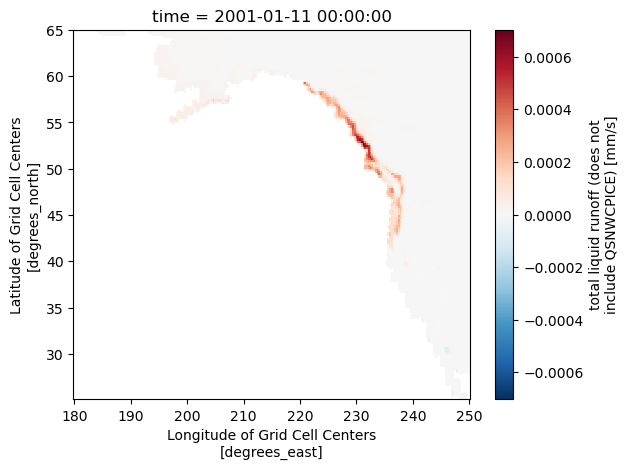

In [41]:
QRUNOFF_hist_rcp26.isel(time=3000).plot();

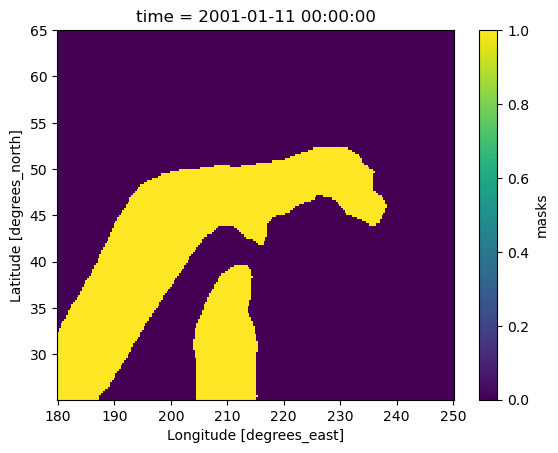

In [42]:
AR.isel(time=3000).plot();

### RCP8.5

In [37]:
%%time
#QRUNOFF_rcp85 = xr.open_dataset(cesm_rcp85_filepath+QRUNOFF_rcp85_file, chunks={'time':500})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # no chunk warning
QRUNOFF_rcp85 = xr.open_dataset(cesm_rcp85_filepath+QRUNOFF_rcp85_file, chunks='auto')['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds) # auto chunking shows chunking in time by 4214 indices (good size)
QRUNOFF_rcp85

CPU times: user 8.65 s, sys: 1.24 s, total: 9.89 s
Wall time: 1min 34s


<xarray.DataArray 'QRUNOFF' (time: 43799, lat: 170, lon: 225)>
dask.array<getitem, shape=(43799, 170, 225), dtype=float32, chunksize=(4214, 73, 109), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 18:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

In [50]:
QRUNOFF_rcp85.chunksizes

Frozen({'time': (4214, 4214, 4214, 4214, 4214, 4214, 4214, 4214, 4214, 4214, 1659), 'lat': (20, 73, 73, 4), 'lon': (78, 109, 38)})

In [38]:
AR_rcp85 = cnet_rcp85.clip(min=1)-1
AR_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 225)>
dask.array<sub, shape=(43800, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00

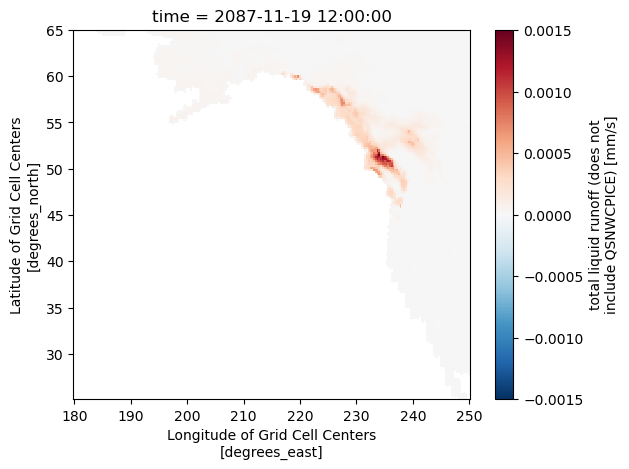

In [62]:
QRUNOFF_rcp85.isel(time=5500).plot();

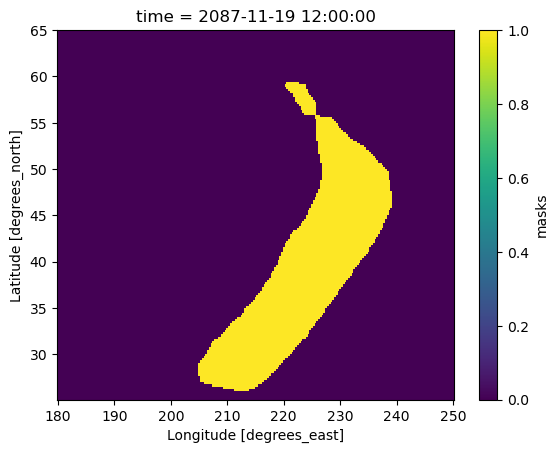

In [63]:
AR_rcp85.isel(time=5500).plot();

## Filter negative QRUNOFF
Negative QRUNOFF can occur when evaporation from lakes exceeds surface (QOVER) + subsurface (QDRAI) runoff.\
Suggestion: filter gridcells that have frequent, large negative QRUNOFF and especially gricells that are negative in the time average. Grid cells with occasional negative QRUNOFF can be zeroed out.

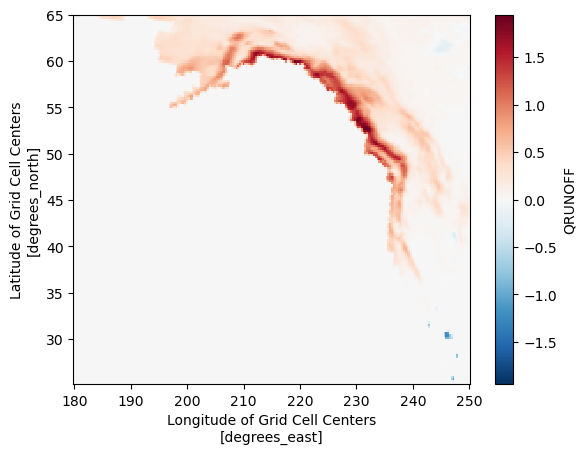

In [75]:
# total historical runoff (with negatives...)
QRUNOFF_hist.sum(dim='time').plot()

In [76]:
# range of values in the sum
print(QRUNOFF_hist.sum(dim='time').max().values, QRUNOFF_hist.sum(dim='time').min().values)

1.9487551 -1.2476085


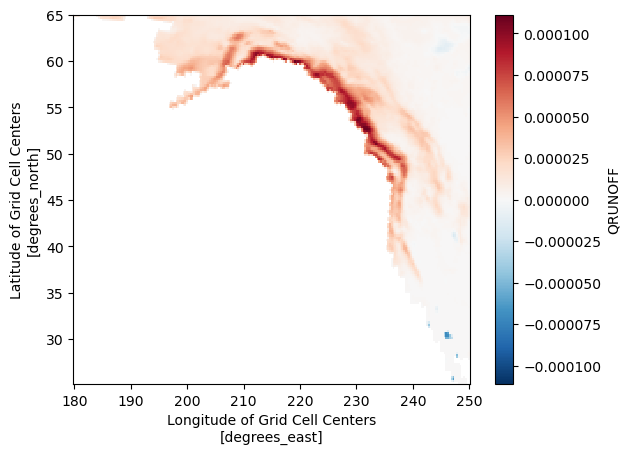

In [54]:
# mean runoff - still some negatives in the mean (frequent)
QRUNOFF_hist.mean(dim='time').plot();

In [56]:
# filter for negative gridcells
QRUNOFF_negs = QRUNOFF_hist.where(QRUNOFF_hist<0)
QRUNOFF_negs

<xarray.DataArray 'QRUNOFF' (time: 17520, lat: 170, lon: 225)>
dask.array<where, shape=(17520, 170, 225), dtype=float32, chunksize=(740, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

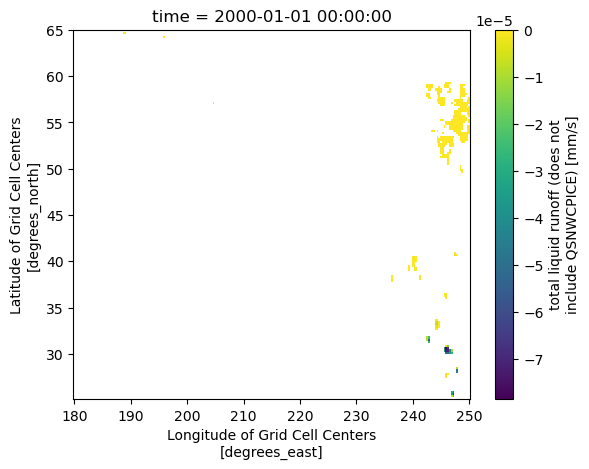

In [57]:
QRUNOFF_negs.isel(time=0).plot();

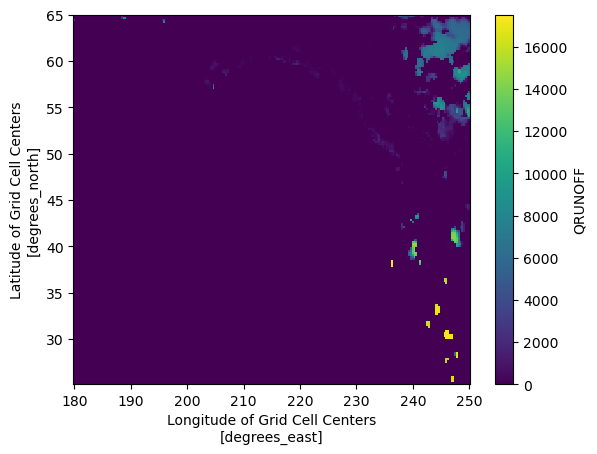

In [66]:
# make a binary count of negative instances at each gridcell
QRUNOFF_negs_sum = QRUNOFF_hist.where(QRUNOFF_hist<0).count(dim='time')
QRUNOFF_negs_sum.plot();

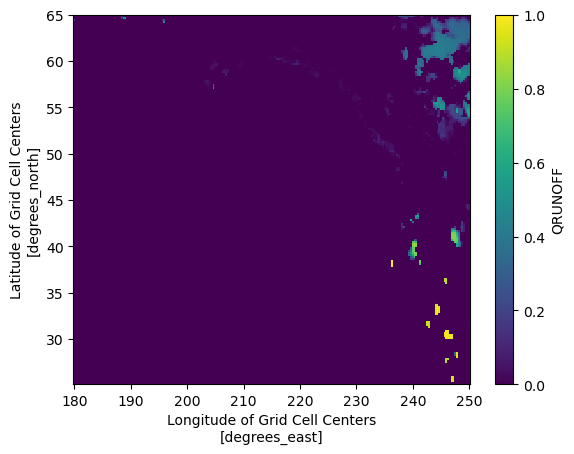

In [69]:
# percentage of total timesteps
QRUNOFF_negs_percent = QRUNOFF_hist.where(QRUNOFF_hist<0).count(dim='time')/len(QRUNOFF_hist.time)
QRUNOFF_negs_percent.plot();

Some gridcells are nearly always negative, others are ~40-50% of the time -- what is 'frequent'?

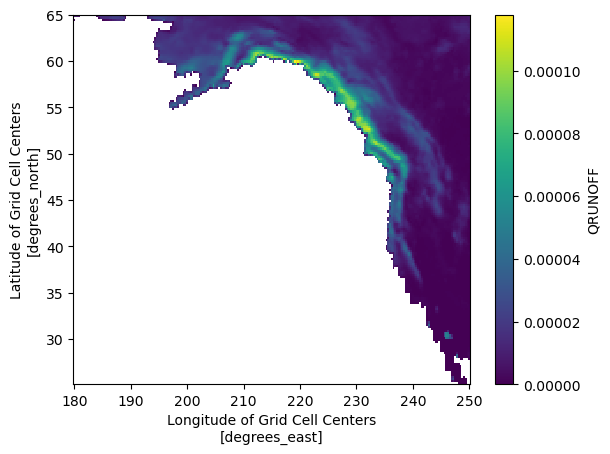

In [70]:
# filter all negatives and compare
QRUNOFF_filter = QRUNOFF_hist_rcp26.where(QRUNOFF_hist_rcp26>0)
QRUNOFF_filter.mean(dim='time').plot();

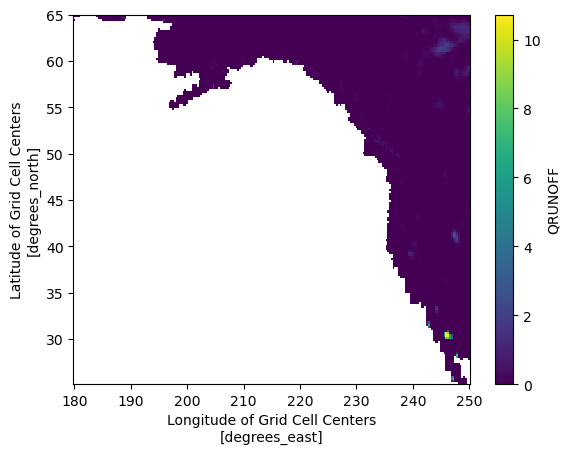

In [76]:
# diff from unfiltered mean plot (should this be mean of diff?); convert mm/s to mm/day
((QRUNOFF_filter.mean(dim='time') - QRUNOFF_hist_rcp26.mean(dim='time'))*86400).plot();

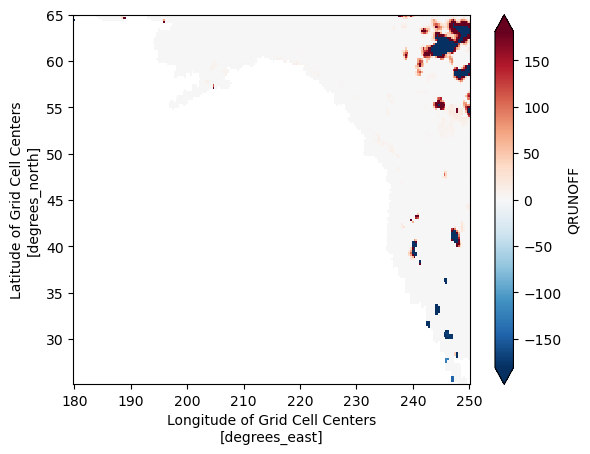

In [79]:
# percent diff
(100*(QRUNOFF_filter.mean(dim='time') - QRUNOFF_hist_rcp26.mean(dim='time'))/QRUNOFF_hist_rcp26.mean(dim='time')).plot(robust=True);

Some of these % diffs can be large (>100%). Since the numerator is always greater than 0 (mean of the filtered values is greater than mean of unfiltered values), the sign of the percent diff is coming from the sign of the mean of unfiltered values.

In [40]:
# hist
QRUNOFF_filter = QRUNOFF_hist_rcp26.where(QRUNOFF_hist_rcp26>0)

In [41]:
# rcp8.5
QRUNOFF_rcp85_filter = QRUNOFF_rcp85.where(QRUNOFF_rcp85>0)

## Match ARs and QRUNOFF

In [81]:
# total runoff overlapping with AR - still some negatives persist
#QRUNOFF_AR = QRUNOFF_hist_rcp26.where(AR==1).sum(dim='time')

# total runoff overlapping with AR - positive gridcells only
QRUNOFF_AR = QRUNOFF_filter.where(AR==1).sum(dim='time')
QRUNOFF_AR

<xarray.DataArray 'QRUNOFF' (lat: 170, lon: 225)>
dask.array<sum-aggregate, shape=(170, 225), dtype=float32, chunksize=(170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0

In [82]:
print(QRUNOFF_AR.max().values, QRUNOFF_AR.min().values)

0.9455112 0.0


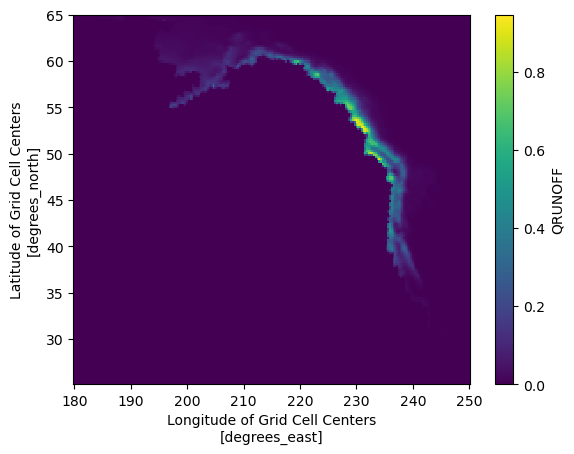

In [83]:
QRUNOFF_AR.plot();

In [92]:
# runoff overlapping with AR at each gridcell / timepoint
QRUNOFF_AR_time = QRUNOFF_filter.where(AR==1)
QRUNOFF_AR_time

<xarray.DataArray 'QRUNOFF' (time: 46720, lat: 170, lon: 225)>
dask.array<where, shape=(46720, 170, 225), dtype=float32, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

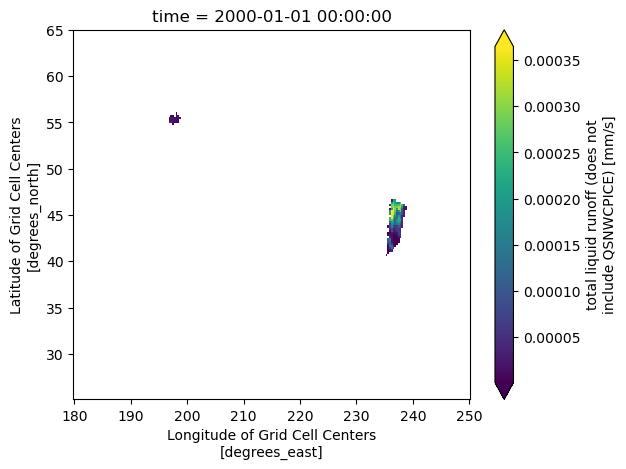

In [93]:
QRUNOFF_AR_time.isel(time=0).plot(robust=True);

In [42]:
def calc_runoff_AR(QRUNOFF, AR):

    # runoff overlapping with AR
    QRUNOFF_AR = QRUNOFF.where(AR==1).sum(dim='time')
    
    # total runoff
    QRUNOFF_sum = QRUNOFF.sum(dim='time')
    
    # proportion of runoff overlapping with AR
    QRUNOFF_AR_frac = 100*(QRUNOFF_AR/QRUNOFF_sum)
    
    # seasonal breakdown
    QRUNOFF_AR_byseason = QRUNOFF.where(AR==1).groupby("time.season").sum(dim='time')
    QRUNOFF_sum_byseason = QRUNOFF.groupby("time.season").sum(dim='time')
    QRUNOFF_AR_frac_byseason = 100*(QRUNOFF_AR_byseason/QRUNOFF_sum_byseason)
    
    # return annual total and by season
    return(QRUNOFF_AR_frac, QRUNOFF_AR_frac_byseason)

In [43]:
# return seasonal values for plots
#QRUNOFF_AR_frac, QRUNOFF_AR_frac_byseason = calc_runoff_AR(QRUNOFF_hist, AR)
#QRUNOFF_AR_frac, QRUNOFF_AR_frac_byseason = calc_runoff_AR(QRUNOFF_hist_rcp26, AR)

QRUNOFF_AR_frac, QRUNOFF_AR_frac_byseason = calc_runoff_AR(QRUNOFF_filter, AR)
QRUNOFF_AR_frac_rcp85, QRUNOFF_AR_frac_byseason_rcp85 = calc_runoff_AR(QRUNOFF_rcp85_filter, AR_rcp85)

In [44]:
QRUNOFF_AR_frac_byseason

<xarray.DataArray 'QRUNOFF' (season: 4, lat: 170, lon: 225)>
dask.array<mul, shape=(4, 170, 225), dtype=float32, chunksize=(1, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [45]:
QRUNOFF_AR_frac_byseason = QRUNOFF_AR_frac_byseason.persist()

In [46]:
print(QRUNOFF_AR_frac_byseason.max().values, QRUNOFF_AR_frac_byseason.min().values)

52.65634 0.0


/glade/derecho/scratch/kdagon/tmp/ipykernel_31422/2186457582.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greens', 16)


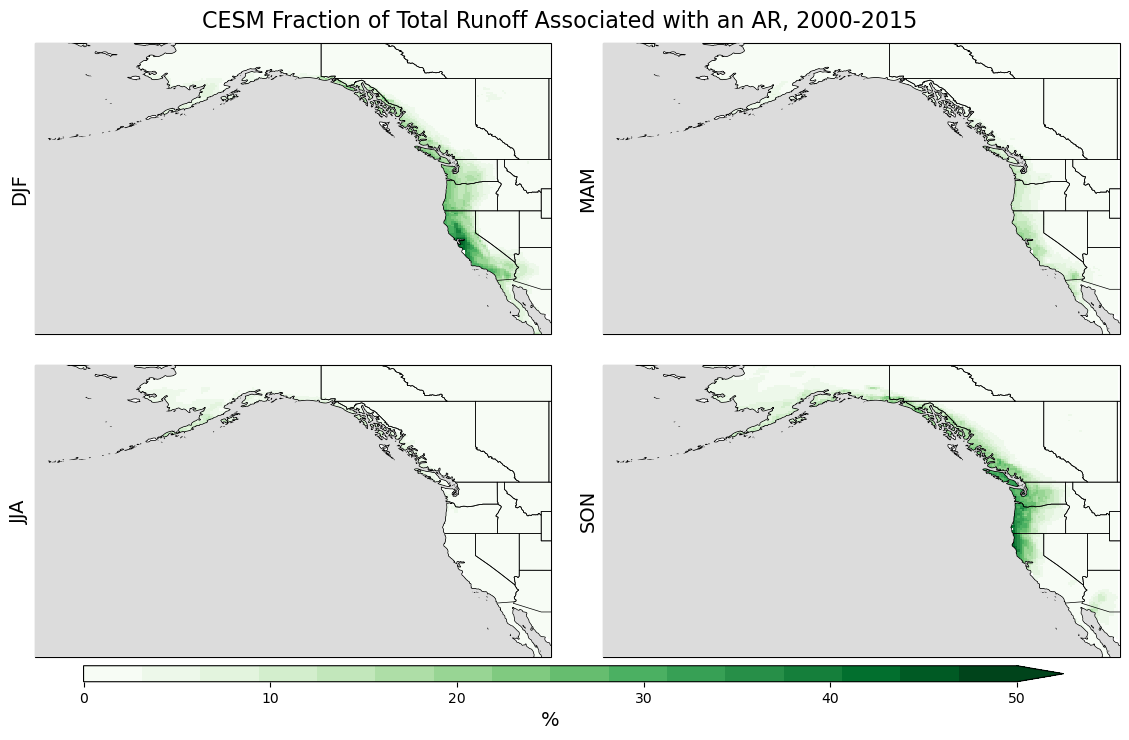

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 50

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(QRUNOFF_AR_frac_byseason.sel(season=season), coord=QRUNOFF_AR_frac_byseason.lon)
    lat = QRUNOFF_AR_frac_byseason.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree()) # helps prevent white space at edges
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Total Runoff Associated with an AR, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/QRUNOFF_AR_WUS_CESM_hist_rcp26_byseason.png', bbox_inches='tight')

In [47]:
QRUNOFF_AR_frac_byseason_rcp85 = QRUNOFF_AR_frac_byseason_rcp85.persist()

In [48]:
print(QRUNOFF_AR_frac_byseason_rcp85.max().values, QRUNOFF_AR_frac_byseason_rcp85.min().values)

72.16267 0.0


/glade/derecho/scratch/kdagon/tmp/ipykernel_31422/1838998445.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greens', 16)


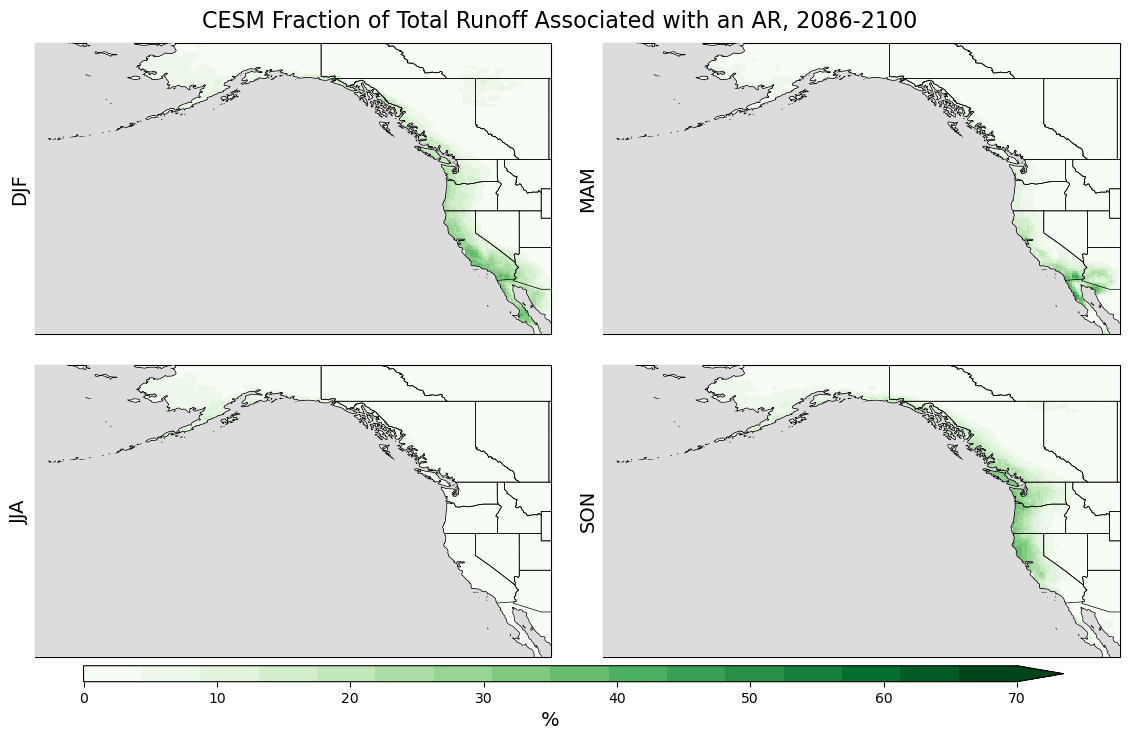

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 70

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(QRUNOFF_AR_frac_byseason_rcp85.sel(season=season), coord=QRUNOFF_AR_frac_byseason_rcp85.lon)
    lat = QRUNOFF_AR_frac_byseason_rcp85.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree()) # helps prevent white space at edges
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Total Runoff Associated with an AR, 2086-2100', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/QRUNOFF_AR_WUS_CESM_rcp85_byseason.png', bbox_inches='tight')

### Diff plots

In [49]:
QRUNOFF_AR_frac_byseason_diff = QRUNOFF_AR_frac_byseason_rcp85 - QRUNOFF_AR_frac_byseason

In [50]:
QRUNOFF_AR_frac_byseason_diff = QRUNOFF_AR_frac_byseason_diff.persist()

In [51]:
print(QRUNOFF_AR_frac_byseason_diff.max().values, QRUNOFF_AR_frac_byseason_diff.min().values)

70.51684 -30.564291


/glade/derecho/scratch/kdagon/tmp/ipykernel_31422/4174799696.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


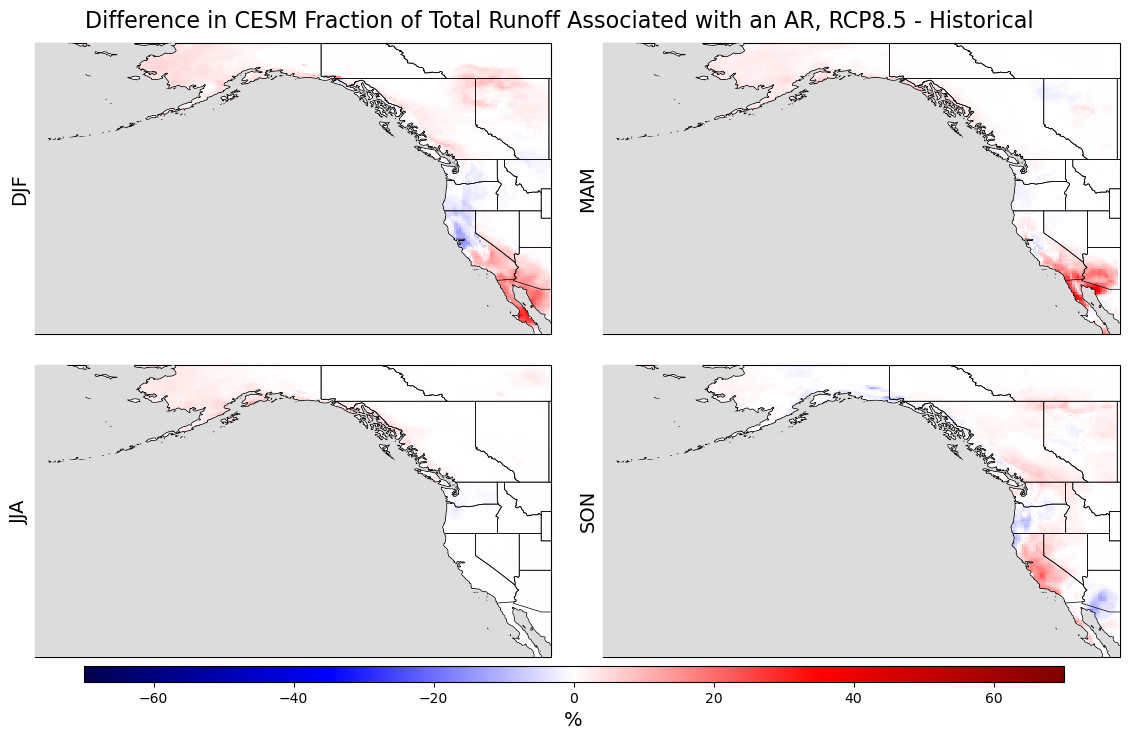

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# difference plot colormap
cmap=plt.cm.get_cmap('seismic')

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(QRUNOFF_AR_frac_byseason_diff.sel(season=season), coord=QRUNOFF_AR_frac_byseason_diff.lon)
    lat = QRUNOFF_AR_frac_byseason_diff.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=-70, vmax=70, transform=ccrs.PlateCarree())
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree()) # helps prevent white space at edges
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('Difference in CESM Fraction of Total Runoff Associated with an AR, RCP8.5 - Historical', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/QRUNOFF_AR_WUS_CESM_diff_byseason.png', bbox_inches='tight')

### Climatological Line Plots

In [52]:
def calc_runoff_AR_time(QRUNOFF, AR):

    # runoff overlapping with AR
    QRUNOFF_AR = QRUNOFF.where(AR==1).sum(dim=('lat','lon'))
    
    # total runoff
    QRUNOFF_sum = QRUNOFF.sum(dim=('lat','lon'))
    
    # proportion of runoff overlapping with AR
    QRUNOFF_AR_frac = 100*(QRUNOFF_AR/QRUNOFF_sum)
    
    # return annual total and by season
    return(QRUNOFF_AR_frac)

In [53]:
QRUNOFF_AR_frac_time = calc_runoff_AR_time(QRUNOFF_filter, AR)
QRUNOFF_AR_frac_time_rcp85 = calc_runoff_AR_time(QRUNOFF_rcp85_filter, AR_rcp85)

In [54]:
QRUNOFF_AR_frac_time 

<xarray.DataArray 'QRUNOFF' (time: 46720)>
dask.array<mul, shape=(46720,), dtype=float32, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

In [55]:
# mean by month of year
QRUNOFF_AR_frac_time_monthofyear  =QRUNOFF_AR_frac_time.groupby("time.month").mean().persist()
# standard deviation
QRUNOFF_AR_frac_time_monthofyear_std = QRUNOFF_AR_frac_time.groupby("time.month").std().persist()

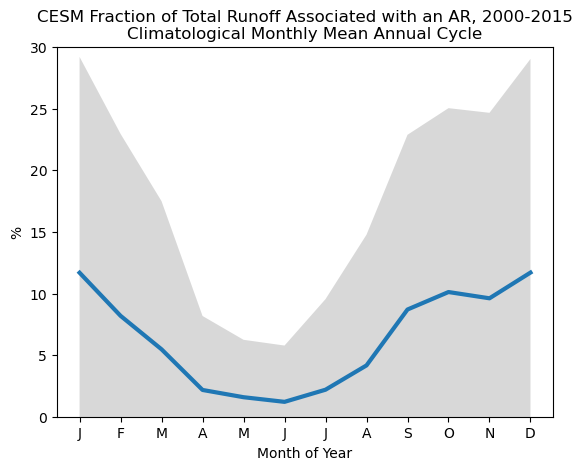

In [58]:
# with fill for standard deviation
plt.plot(QRUNOFF_AR_frac_time_monthofyear.month, QRUNOFF_AR_frac_time_monthofyear, linewidth=3)
plt.fill_between(QRUNOFF_AR_frac_time_monthofyear.month, QRUNOFF_AR_frac_time_monthofyear-QRUNOFF_AR_frac_time_monthofyear_std, 
                QRUNOFF_AR_frac_time_monthofyear+QRUNOFF_AR_frac_time_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([0,30])
plt.title('CESM Fraction of Total Runoff Associated with an AR, 2000-2015\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/QRUNOFF_AR_monthofyear_withstdev_WUS_CESM_hist_rcp26.png', bbox_inches='tight')

In [59]:
# mean by time of day
QRUNOFF_AR_frac_time_timeofday = QRUNOFF_AR_frac_time.groupby("time.hour").mean().persist()
# standard deviation
QRUNOFF_AR_frac_time_timeofday_std = QRUNOFF_AR_frac_time.groupby("time.hour").std().persist()

In [60]:
# 3hrly frequency
QRUNOFF_AR_frac_time_timeofday.hour

<xarray.DataArray 'hour' (hour: 8)>
array([ 0,  3,  6,  9, 12, 15, 18, 21])
Coordinates:
  * hour     (hour) int64 0 3 6 9 12 15 18 21

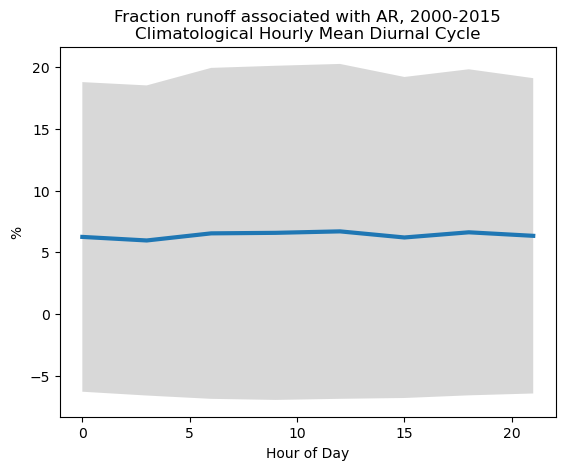

In [62]:
plt.plot(QRUNOFF_AR_frac_time_timeofday.hour, QRUNOFF_AR_frac_time_timeofday, linewidth=3)
plt.fill_between(QRUNOFF_AR_frac_time_timeofday.hour, QRUNOFF_AR_frac_time_timeofday-QRUNOFF_AR_frac_time_timeofday_std, 
                QRUNOFF_AR_frac_time_timeofday+QRUNOFF_AR_frac_time_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
#plt.ylim([0,30]) # withstdev
plt.title('Fraction runoff associated with AR, 2000-2015\nClimatological Hourly Mean Diurnal Cycle');

In [63]:
# RCP8.5
# mean by month of year
QRUNOFF_AR_frac_time_monthofyear_rcp85 = QRUNOFF_AR_frac_time_rcp85.groupby("time.month").mean().persist()
# standard deviation
QRUNOFF_AR_frac_time_monthofyear_std_rcp85 = QRUNOFF_AR_frac_time_rcp85.groupby("time.month").std().persist()

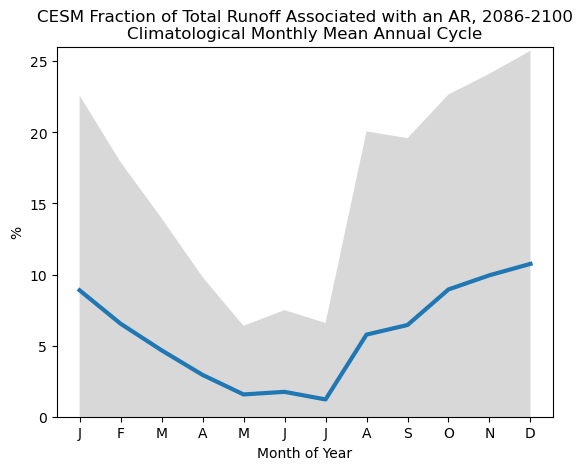

In [71]:
# with fill for standard deviation
plt.plot(QRUNOFF_AR_frac_time_monthofyear_rcp85.month, QRUNOFF_AR_frac_time_monthofyear_rcp85, linewidth=3)
plt.fill_between(QRUNOFF_AR_frac_time_monthofyear_rcp85.month, QRUNOFF_AR_frac_time_monthofyear_rcp85-QRUNOFF_AR_frac_time_monthofyear_std_rcp85, 
                QRUNOFF_AR_frac_time_monthofyear_rcp85+QRUNOFF_AR_frac_time_monthofyear_std_rcp85, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([0,26])
plt.title('CESM Fraction of Total Runoff Associated with an AR, 2086-2100\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/QRUNOFF_AR_monthofyear_withstdev_WUS_CESM_hist_rcp85.png', bbox_inches='tight')

In [65]:
# differences (TO DO: think about how std works here)
QRUNOFF_AR_frac_time_monthofyear_diff = QRUNOFF_AR_frac_time_monthofyear_rcp85 - QRUNOFF_AR_frac_time_monthofyear

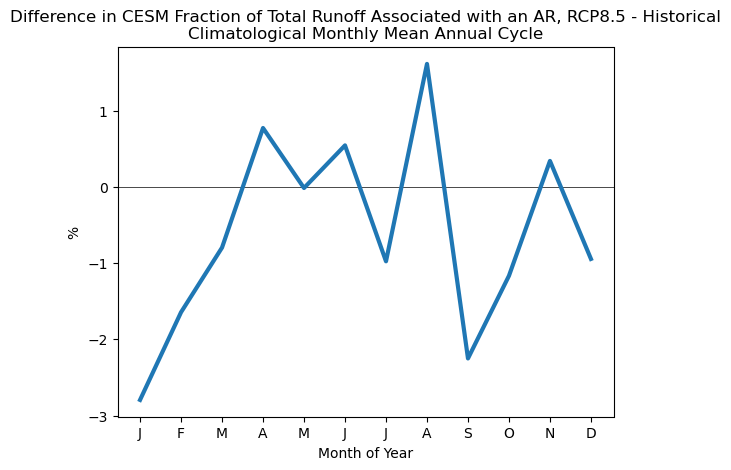

In [72]:
plt.plot(QRUNOFF_AR_frac_time_monthofyear_diff.month, QRUNOFF_AR_frac_time_monthofyear_diff, linewidth=3, zorder=10)
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
#plt.ylim([-10,10])
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=0.5)
plt.title('Difference in CESM Fraction of Total Runoff Associated with an AR, RCP8.5 - Historical\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/QRUNOFF_AR_monthofyear_WUS_CESM_diff.png', bbox_inches='tight')

In [73]:
client.close()
cluster.close()

## TO DO 
- Think about whether all/any negative QRUNOFF should be filtered out
- Add offline river modeling? To really get at flooding impacts
- CESM "IVT" output along with AR conditions? Would need to derive 3hrly IVT from existing output or use 6hrly IVT (not avail for RCP2.6, 2006-2015)